# Title: Deserted neighborhood: Reason for crime?
Team: Bhanu Phanindra, Phani Teja Kesha

   <b>Overview:</b>We are working on vacant buildings data set. We planning to derive relation if possible with factors like crime, service requests and tax affecting vacancy of buildings in area. This dataset contains building addresses, police district and NoticeDate of buildings that are vacant. It does not contain any info regarding non-vacant buildings.

Datasets used are vacant builings, Real_PropertyTaxes, 311_Customer_Service_Requests and BPD_Part_1_Victim_Based_Crime_Data.

The following are the technical details given in openbaltimore about <b> service requests </b>dataset. Number of rows and columns are 3.25M and 22 respectively where each row is a service request. Despite being huge dataset it has large number of downloads. A table preview containging all columns is given in the same page which gives info about what we can expect from this dataset even before we download. Other than these technical details about dataset nothing else is mentioned about services or what this dataset is actually. 

Dataset looks almost clean with some missing values in few columns. Looks like particular standard is followed for data entry. So there is not much ambiguity in notation. Although format of StatusDate, DueDate and CloseDate is same, CreatedDate is slightly different. I also spotted one duplicate row in 50 rows, which is mentioned as duplicate in service request itself. I think it only possible to get duplicate entries only when service request method is API. This can be investigated further when processing the data. Also may be not all duplicate requests are identified, there is possibility that different service request methods have been tried for exact same service.
 

One of the redundent information is GeoLocation, since Latitude and Longitude have their own colums. GeoLocation column can be dropped with out any worries. Before looking at output of tail(50) I assumed SRRecordID to be integer. But it looks like some random text is present at end of digits. Not sure whether it is intended or faulty recordID. Since it is just an Id it does not matter much.

Some technical details about <b> vacant builings </b>dataset given in open baltimore are Number of rows and columns are 16.7k and 9 respectively where each row is contains information about vacant building. It has 5.4K downloads and updated twice a month. There are not many null values in the dataset only one row in which there is not building address, so lets go ahead and delete the row which has a null value. To make the dataset clean.

Some technical details about <b>property tax</b> dataset given in open baltimore are Number of rows and columns are 239k and 16 respectively where each row is contains tax information for each builing.

<br>
1)There are some NULL values in the column AmountDue.
<br>
2) Null values in columns CityTax and StateTax but the NULL values are not seen as frequently as seen in the AmountDue.
<br>
3) There are only two values in the column ResCode that is either it is a princial residence or not a principal residence.
<br>
4) The CouncilDistrict column looks like a code for the area but it is given in float value even though all values seems to be integer
<br>
5) There are some null values in columns Neighbourhood, PoliceDistrict, CouncilDistrict, Location. There is a row in which all these are null, i suspect all these to be null if any one of the value is null.

In [103]:
#All the imports for the notebook can be found here 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_vacant = pd.read_csv('Vacant_Buildings.csv') # Reading the data into the dataframe df

In [3]:
df_vacant.head()        #checking the first 5 rows in the dataset

,ReferenceID,Block,Lot,BuildingAddress,NoticeDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location
0,0002 019 031016,0002,019,1909 W NORTH AVE,03/10/2016,EASTERWOOD,WESTERN,7,"(39.30952601, -76.64848892)"
1,0007 057 031116,0007,057,1734 APPLETON ST,03/11/2016,EASTERWOOD,WESTERN,7,"(39.30856758, -76.64921157)"
2,0125 012 030816,0125,012,522 N CAREY ST,03/08/2016,HARLEM PARK,WESTERN,9,"(39.29482152, -76.63877572)"
3,0151 009 030716,0151,009,317 N GILMOR ST,03/07/2016,FRANKLIN SQUARE,WESTERN,9,"(39.29261888, -76.64231678)"
4,0074 010 030918,0074,010,945 N MOUNT ST,03/09/2018,Sandtown-Winchester,Western,9,"(39.29975212, -76.64415784)"


In [4]:
len(df_vacant) #Total 16.6k rows in the dataset 

16692

#### Column names with null values count

In [5]:
df_vacant.isnull().sum(axis=0)

ReferenceID        0
Block              0
Lot                0
BuildingAddress    1
NoticeDate         0
Neighborhood       0
PoliceDistrict     0
CouncilDistrict    0
Location           0
dtype: int64

Now let's clean the dataset such that it has no null values and no outliers in the given dataset. To achieve this we can follow some preprocessing techniques like filling with a global value, predicting the value etc.

In [6]:
df_vacant.describe()

,CouncilDistrict
count,16692.000000
mean,9.364186
std,2.775971
min,1.000000
25%,7.000000
50%,9.000000
75%,12.000000
max,14.000000


In [7]:
df_vacant[df_vacant['BuildingAddress'].isnull()]

,ReferenceID,Block,Lot,BuildingAddress,NoticeDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location
5193,0626 026 080217,0626,026,NaN,08/02/2017,Poppleton,Western,11,"(39.28929887, -76.62864465)"


In [8]:
df_vacant = df_vacant[df_vacant['BuildingAddress'].notnull()]

There's is only one null value in the dataset so no harm in removing it from the dataset. The row is removed and the dataset is updated!

In [9]:
df_vacant.isnull().sum(axis=0)

ReferenceID        0
Block              0
Lot                0
BuildingAddress    0
NoticeDate         0
Neighborhood       0
PoliceDistrict     0
CouncilDistrict    0
Location           0
dtype: int64

Now lets check for unique values in each column so that we can find outliers if there are any in dataset.

In [10]:
df_vacant['CouncilDistrict'].unique()

array([ 7,  9, 11, 10, 12, 13,  8,  6,  5,  4, 14,  2,  1,  3],
      dtype=int64)

Its considering the coloumn as type sensitive,convert into a single case for no confusion and to get clearer results

In [11]:
df_vacant['PoliceDistrict'].unique()   

array(['WESTERN', 'Western', 'SOUTHERN', 'Southwestern', 'CENTRAL',
       'Southern', 'EASTERN', 'SOUTHEASTERN', 'SOUTHWESTERN', 'Eastern',
       'Southeastern', 'Northwestern', 'NORTHWESTERN', 'NORTHERN',
       'Notheastern', 'Central', 'Northern', 'NORTHEASTERN'], dtype=object)

Here we see typo, which resulted in duplicate values. This is handled further down in notebook.

In [12]:
df_vacant['PoliceDistrict']=df_vacant['PoliceDistrict'].str.lower()

In [13]:
df_vacant['Neighborhood'].unique()

array(['EASTERWOOD', 'HARLEM PARK', 'FRANKLIN SQUARE',
       'Sandtown-Winchester', 'CARROLLTON RIDGE', 'Boyd-Booth',
       'DOWNTOWN', 'WASHINGTON VILLAGE/PIGTOWN', 'Union Square',
       'Hollins Market', 'OLIVER', 'BROADWAY EAST',
       'New Southwest/Mount Clare', 'MCELDERRY PARK',
       'ELLWOOD PARK/MONUMENT', 'Easterwood',
       'COPPIN HEIGHTS/ASH-CO-EAST', 'Franklin Square',
       'NORTHWEST COMMUNITY ACTION', 'Poppleton', 'ROSEMONT',
       'FRANKLINTOWN ROAD', 'EDGEWOOD', 'Penrose/Fayette Street Outreach',
       'Broadway East', 'Madison-Eastend', 'McElderry Park',
       'Ellwood Park/Monument', 'Franklintown Road', 'Rosemont',
       'East Baltimore Midway', 'Central Park Heights', 'Brooklyn',
       'IRVINGTON', 'CONCERNED CITIZENS OF FOREST PARK', 'FOREST PARK',
       'HANLON-LONGWOOD', 'PARK CIRCLE', 'WOODBERRY', 'BARCLAY',
       'PIMLICO GOOD NEIGHBORS', 'MID-GOVANS',
       'Coldstream Homestead Montebello', 'Oliver', 'BROOKLYN', 'Berea',
       'CARE', 'Bela

In [14]:
df_vacant['PoliceDistrict'].unique()

array(['western', 'southern', 'southwestern', 'central', 'eastern',
       'southeastern', 'northwestern', 'northern', 'notheastern',
       'northeastern'], dtype=object)

In [15]:
len(df_vacant['Lot'].unique())

505

In [16]:
df_vacant['Block'].unique()

array(['0002', '0007', '0125', ..., '8358', '8422', '8434F'], dtype=object)

In [17]:
type(df_vacant.groupby(['PoliceDistrict']).count()['Lot'])

pandas.core.series.Series

The vacant buildings in each police district is counted and plot for police district vs its count is created.<br>
From the below plot we can see following insights.<br>
1. SouthEastern and Northern districts haveleast number of vacant buildings.<br>
2. Western has highest number of vacant buildings.

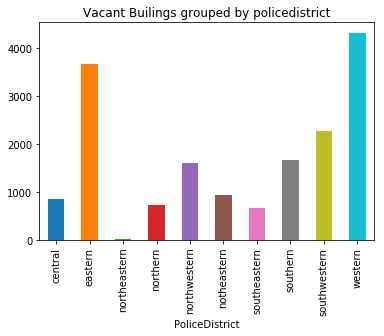

In [18]:
df_vacant.groupby(['PoliceDistrict']).count()['Lot'].plot(kind='bar', title='Vacant Builings grouped by policedistrict')

#### Plot when groupby is used on PoliceDistrict.

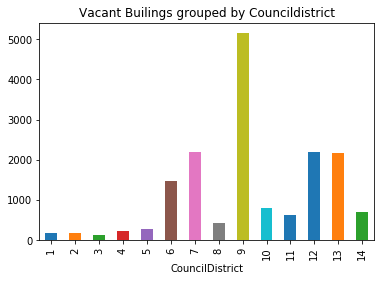

In [19]:
df_vacant.groupby(['CouncilDistrict']).count()['Lot'].plot(kind='bar',title='Vacant Builings grouped by Councildistrict')

The vacant buildings in each council district is counted and plot for council district vs its count is created.<br>
From the below plot we can see following insights.<br>
1. Third council have least number of vacant buildings.<br>
2. Nineth council has highest number of vacant buildings.
3. Maximum is leading other districts by large amount

Checking if most of the Western district vacant buildings fall under council District 9

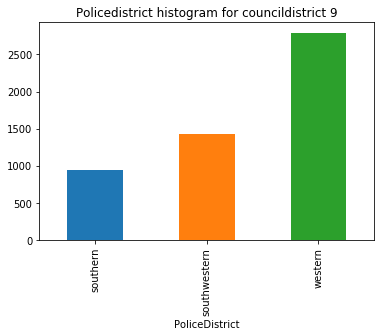

In [20]:
df_vacant[df_vacant['CouncilDistrict'] == 9].groupby('PoliceDistrict').count()['Lot'].plot(kind = 'bar',title='Policedistrict histogram for councildistrict 9')

Not only Most of the western district falls under district 9, it has southern and southwestern incuded in it.

In [21]:
df_vacant = df_vacant[df_vacant['BuildingAddress'].notnull()]
df_vacant.isnull().sum(axis=0)
df_vacant['PoliceDistrict']=df_vacant['PoliceDistrict'].str.lower()
df_date = pd.DataFrame(columns=['Month','Day', 'year'])

The notice date in dataset is of string format with mm/date/year. To perform analysis on this column we convert to standard format which has three columns Month, day and year.

In [22]:
for i in range(0,len(df_vacant)):
    date = df_vacant.iloc[i]['NoticeDate'].split('/')
    df_date.loc[i] = [int(date[0]),int(date[1]),int(date[2])]

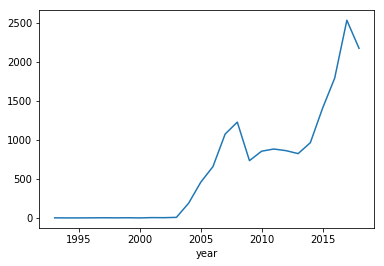

In [23]:
%matplotlib inline
df_date.groupby(['year']).count()['Day'].plot(kind='line')

#### Above plot is vacant buildings vs year of the notice date.


The above plot shows us the number of vacant buildings with respect to the year in notice period. There are some homes which are vacant from 2004. That means there are many buildings which are left vacant from a decade. This may show us that if a builing is vacant from many years probably its going to stay that way for long time.

Now lets divide the time frame in to two buckets of equal span and see how many vacant buildings fall under each bucket.

In [24]:
count = 0
for i in range(0,len(df_date)):
    if df_date.iloc[i]['year']<=2011:
        #print(df_date.iloc[i])
        count+=1
print(count)

6121


Out of the total 16.6K vacant buildings, almost 40% (6121) are being vacant from 2011. 

### Just like Newtons laws of motion if building is vacant it tends to be in vacant state!

In [25]:
from collections import Counter
listDist = []
count = 0
for i in range(0,len(df_date)):
    if df_date.iloc[i]['year']<=2004:
        count+=1
        listDist.append(df_vacant.iloc[i]['PoliceDistrict'])
print(Counter(listDist))

Counter({'western': 87, 'central': 43, 'southwestern': 34, 'eastern': 24, 'northwestern': 9, 'southern': 9, 'notheastern': 6, 'northern': 6, 'southeastern': 1})


We have previosuly seen that western district has the most number of vacant buildings. Looking at the vacant buildings which are vacant from the year 2004. There are 87 buildings which are vacant in western district, which raises our suspicion. Now lets check other datasets to check if there is any correlation with vacant buildings.

#### Lets dive into Crime dataset 

In [27]:
df_crime = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')

In [28]:
df_crime.head(10)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,crimeCaseNumber,Total Incidents
0,07/07/2018,23:53:00,1F,1600 PENTWOOD RD,HOMICIDE,NaN,FIREARM,413.0,NORTHEASTERN,Stonewood-Pentwood-Winsto,-76.58727,39.34782,"(39.34782, -76.58727)",Alley,NaN,1.0
1,07/07/2018,23:50:00,4E,ST & DIVISION ST,COMMON ASSAULT,O,NaN,131.0,CENTRAL,Druid Heights,-76.63936,39.30903,"(39.30903, -76.63936)",STREET,NaN,1.0
2,07/07/2018,23:18:00,4C,2500 PERRING MANOR RD,AGG. ASSAULT,I,OTHER,423.0,NORTHEASTERN,Hamilton Hills,-76.56094,39.37189,"(39.37189, -76.56094)",ROW/TOWNHO,NaN,1.0
3,07/07/2018,22:41:00,9S,3700 S HANOVER ST,SHOOTING,NaN,FIREARM,913.0,SOUTHERN,Brooklyn,-76.61033,39.23703,"(39.23703, -76.61033)",Common Bus,NaN,1.0
4,07/07/2018,22:55:00,4E,LOMBARD ST & LIGHT ST,COMMON ASSAULT,I,NaN,111.0,CENTRAL,Inner Harbor,-76.61362,39.28775,"(39.28775, -76.61362)",CONVENIENC,NaN,1.0
5,07/07/2018,22:18:00,4C,1800 W FRANKLIN ST,AGG. ASSAULT,I,OTHER,722.0,WESTERN,Harlem Park,-76.64652,39.29388,"(39.29388, -76.64652)",ROW/TOWNHO,NaN,1.0
6,07/07/2018,21:40:00,3B,1000 SAINT PAUL ST,ROBBERY - STREET,NaN,NaN,141.0,CENTRAL,Mid-Town Belvedere,-76.61436,39.30165,"(39.30165, -76.61436)",NaN,NaN,1.0
7,07/07/2018,21:16:00,4E,2000 E BALTIMORE ST,COMMON ASSAULT,I,NaN,212.0,SOUTHEASTERN,Butcher's Hill,-76.58809,39.29172,"(39.29172, -76.58809)",ROW/TOWNHO,NaN,1.0
8,07/07/2018,21:08:00,6D,400 E 20TH ST,LARCENY FROM AUTO,I,NaN,341.0,EASTERN,Barclay,-76.61049,39.31244,"(39.31244, -76.61049)",APT/CONDO,NaN,1.0
9,07/07/2018,20:19:00,9S,4900 SINCLAIR LA,SHOOTING,NaN,FIREARM,443.0,NORTHEASTERN,Frankford,-76.55088,39.32101,"(39.32101, -76.55088)",Street,NaN,1.0


In [29]:
df_crime.isnull().sum(axis=0)

CrimeDate               0
CrimeTime               0
CrimeCode               0
Location             3971
Description           248
Inside/Outside      25566
Weapon             261423
Post                  295
District              112
Neighborhood         4213
Longitude            3969
Latitude             3969
Location 1           4755
Premise             21012
crimeCaseNumber    335571
Total Incidents       847
dtype: int64

There are many null values in the dataset. Restricting the cleaning part to required columns only.

In [109]:
len(df_crime)

335571

In [31]:
df_crime['Total Incidents'].unique()

array([ 1., nan])

In [32]:
df_crime =  df_crime.drop(columns=['crimeCaseNumber', 'Total Incidents'])

In [33]:
df_crime['District'] = df_crime['District'].fillna(0)

In [34]:
df_crime['District'].unique()

array(['NORTHEASTERN', 'CENTRAL', 'SOUTHERN', 'WESTERN', 'SOUTHEASTERN',
       'EASTERN', 'NORTHWESTERN', 'SOUTHWESTERN', 'NORTHERN', 0],
      dtype=object)

Even though Western district has highest number of vacant buildings, it has least crime rate. This goes completely opposite to our intuition. Reason for this has something to do be western district has more number of buildings automatically leading to more number of vacant buildings. To find the truth we must find percentage of vacant buildings in District rather than number of vacant buildings. Since vacant buildings dataset does not contain any information about non vacant buildings, we will use propery tax dataset to these details which contains buildings information. We consider these buildings as non-vacant and calculate percentage of vacant buildings.

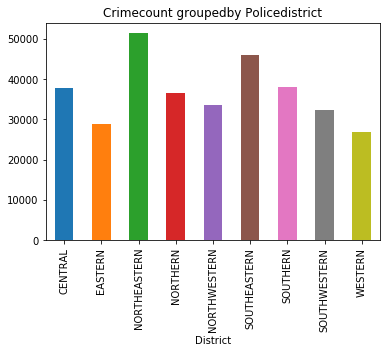

In [35]:
df_crime[df_crime['District'] != 0].groupby(['District']).count()['Location'].plot(kind='bar',title='Crimecount groupedby Policedistrict')

The Crime incidents in each police district is counted and plot for police district vs its count is created.<br>
From the above plot we can see following insights.<br>
1. Western and Easter districts havel east number of crime incidents.<br>
2. Northeastern has highest number of crime incidents.

#### Now let's check an Property taxes dataset

The reason why we wanted to use property dataset for the following <br>
1) we can find non vacant buildings <br>
2) we can find number of buildings in each police district <br>
3) Can a build a model which will learn if a building is vacant or not <br>
This is done by considering the buildings which are present in property tax dataset and not presnt in vacant building dataset as Non vacant buildings.

In [36]:
df_property = pd.read_csv("Real_Property_Taxes.csv")

In [37]:
df_property.head(10)

,PropertyID,Block,Lot,Ward,Sect,PropertyAddress,LotSize,CityTax,StateTax,ResCode,AmountDue,AsOfDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location
0,0001002,0001,002,15,370,2043 W NORTH AVE,14X83-10,1112.76,55.44,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30941619, -76.65109034)"
1,5918064,5918,064,26,380,3429 SHANNON DR,18X91-9,2801.01,139.55,PRINCIPAL RESIDENCE,1356.50,09/29/2018,Belair-Edison,Notheastern,13.0,"(39.3229146, -76.56235554)"
2,0001004,0001,004,15,370,2039 W NORTH AVE,14X83-10,472.08,23.52,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30941951, -76.65099026)"
3,0001005,0001,005,15,370,2037 W NORTH AVE,14X83-10,472.08,23.52,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30942111, -76.65094166)"
4,0001006,0001,006,15,370,2035 W NORTH AVE,14X83-10,247.28,12.32,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30942277, -76.65089166)"
5,4179P033,4179P,033,26,340,3811 LYNDALE AVE,14X100,2032.19,101.25,NOT A PRINCIPAL RESIDENCE,2123.28,07/01/2018,Belair-Edison,Notheastern,13.0,"(39.31680208, -76.56505749)"
6,0001009,0001,009,15,370,2029 W NORTH AVE,14X83-10,472.08,23.52,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30942756, -76.65074605)"
7,0001010,0001,010,15,370,2027 W NORTH AVE,14X83-10,472.08,23.52,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30942925, -76.65069531)"
8,0001011,0001,011,15,370,2025 W NORTH AVE,14X83-10,472.08,23.52,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30943089, -76.65064581)"
9,0001012,0001,012,15,370,2023 W NORTH AVE,14X83-10,472.08,23.52,NOT A PRINCIPAL RESIDENCE,NaN,06/04/2018,Easterwood,Western,7.0,"(39.30943253, -76.65059631)"


In [38]:
df_property.isnull().sum(axis=0)

PropertyID             0
Block                  0
Lot                    0
Ward                   0
Sect                   0
PropertyAddress        5
LotSize                0
CityTax            18976
StateTax           18778
ResCode                0
AmountDue          98686
AsOfDate               0
Neighborhood       16122
PoliceDistrict     16122
CouncilDistrict    16094
Location           16082
dtype: int64

In [39]:
df_property.dtypes

PropertyID          object
Block               object
Lot                 object
Ward                 int64
Sect                 int64
PropertyAddress     object
LotSize             object
CityTax            float64
StateTax           float64
ResCode             object
AmountDue          float64
AsOfDate            object
Neighborhood        object
PoliceDistrict      object
CouncilDistrict    float64
Location            object
dtype: object

In [40]:
df_property.describe()

,Ward,Sect,CityTax,StateTax,AmountDue,CouncilDistrict
count,238509.000000,238509.000000,2.195330e+05,219731.000000,1.398230e+05,222415.000000
mean,18.661505,145.082534,4.056272e+03,205.074626,3.336122e+03,7.594290
std,8.197253,133.920428,3.532905e+04,1817.644405,2.882668e+04,4.043136
min,1.000000,0.000000,2.250000e+00,0.110000,1.000000e-02,1.000000
25%,12.000000,50.000000,8.092800e+02,40.320000,6.894200e+02,4.000000
50%,20.000000,110.000000,2.367140e+03,118.050000,1.539640e+03,8.000000
75%,27.000000,200.000000,3.635020e+03,181.100000,2.846385e+03,11.000000
max,50.000000,690.000000,6.276443e+06,312705.340000,3.983104e+06,14.000000


Since only thing that is important for us is PropertyAddress, check for null values in that column and try to join with address in vacant buildings dataset.

In [41]:
df_property[df_property['PropertyAddress'].isnull()]
df_property['PoliceDistrict'] = df_property['PoliceDistrict'].fillna(0)

In [42]:
df_property = df_property[df_property['PropertyAddress'].notnull()]

In [43]:
print(len(df_property))

238504


In [44]:
df_join = df_property.join(df_vacant, lsuffix='property', rsuffix='vacant', how='inner')

In [45]:
len(df_property)

238504

In [46]:
len(df_vacant)

16691

In [47]:
len(df_join)

16691

In [48]:
list(df_property.groupby(['PoliceDistrict']).count()['Ward'])

[16121, 8938, 19539, 30503, 23621, 42261, 27163, 25251, 25706, 19401]

In [49]:
df_property.groupby(['PoliceDistrict']).count()['Ward']

PoliceDistrict
0               16121
Central          8938
Eastern         19539
Northern        30503
Northwestern    23621
Notheastern     42261
Southeastern    27163
Southern        25251
Southwestern    25706
Western         19401
Name: Ward, dtype: int64

Again results are surprising. Number of buildings in Western district is low side(least but one). This means not only there few buildings in western district of baltimore, but most of them are vacant. Previously, we assumed that western district has many buildings is a wrong assumption. So that means there is a less crime rate in vacant neighboorhood.

#### If buidlings are vacant - No crimes! Voila

In [50]:
df_vacant.groupby(['PoliceDistrict']).count()['Lot']

PoliceDistrict
central          848
eastern         3659
northeastern       9
northern         718
northwestern    1613
notheastern      945
southeastern     656
southern        1665
southwestern    2263
western         4315
Name: Lot, dtype: int64

In [51]:
policeDistrict_property = dict(df_property.groupby(['PoliceDistrict']).count()['Ward'])

In [52]:
policeDistrict_vacant = dict(df_vacant.groupby(['PoliceDistrict']).count()['Lot'])

In [53]:
policeDistrict_vacant['northeastern'] = 954

This loop is used to calculate relative vacancies in each police district.

In [54]:
relative_vacancy = {}
for key in policeDistrict_property:
    if key != 0:
        relative_vacancy[key] = (policeDistrict_vacant[key.lower()] / policeDistrict_property[key]) * 100

In [55]:
print(relative_vacancy)

{'Central': 9.487581114343254, 'Eastern': 18.72664926557142, 'Northern': 2.353866832770547, 'Northwestern': 6.828669404343593, 'Notheastern': 2.2361042095549086, 'Southeastern': 2.4150498840334276, 'Southern': 6.593798265415231, 'Southwestern': 8.803392204154672, 'Western': 22.24112159167053}


Western leads by large margin followed by Eastern just like in first bar graph. At this point big picture is starting to get clear. Western district has least number of crimes because there are not many non vacant buildings and more vacant buildings which means less population and less crimes.

Let's try to find if there is any relation between 311 requests and vacant buildings.

#### Customer Service Requests

In [56]:
df_request = pd.read_csv("311_Customer_Service_Requests.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,10,11,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
df_request.head(2)

,SRRecordID,ServiceRequestNum,SRType,MethodReceived,CreatedDate,SRStatus,StatusDate,DueDate,CloseDate,Agency,...,Outcome,Address,ZipCode,Neighborhood,CouncilDistrict,PoliceDistrict,PolicePost,Latitude,Longitude,GeoLocation
0,1065701056,14-00000008,TRS-Parking Complaint,API,01/01/2014 12:28:25 AM,Closed,01/01/2014 01:24:55 AM,01/02/2014 12:28:25 AM,01/01/2014 01:24:55 AM,Transportation,...,After parking control hours - contact the police.,"16 W CROSS ST, BALTIMORE CITY, MD, 21230",21230,Federal Hill,11.0,SOUTHERN,942,39.276713,-76.615362,"(39.2767132435659, -76.6153615433316)"
1,1065701081,14-00000009,TRS-Parking Complaint,API,01/01/2014 12:28:31 AM,Closed,01/01/2014 01:25:33 AM,01/02/2014 12:28:31 AM,01/01/2014 01:25:33 AM,Transportation,...,After parking control hours - contact the police.,"11 W CROSS ST, BALTIMORE CITY, MD, 21230",21230,Federal Hill,11.0,SOUTHERN,942,39.276759,-76.614955,"(39.2767585857716, -76.6149550612581)"


In [58]:
df_request["PoliceDistrict"].unique()

array(['SOUTHERN', 'NORTHERN', 'EASTERN', 'NORTHWESTERN', 'SOUTHEASTERN',
       nan, 'CENTRAL', 'NORTHEASTERN', 'WESTERN', 'SOUTHWESTERN', 'EAST',
       'WEST', 'Northeastern', 'Southeastern', 'Central', 'Northern',
       'Southern', 'Northwestern', 'Southwestern', 'Western', 'Eastern'],
      dtype=object)

In [59]:
df_request_null = df_request.dropna()

In the dataset even if we drop all null valued rows, we still are left with 2.5 million rows.

In [60]:
len(df_request) - len(df_request_null)

747339

In [61]:
df_request.isnull().sum(axis=0)

SRRecordID                0
ServiceRequestNum         0
SRType                   11
MethodReceived            0
CreatedDate               0
SRStatus                  0
StatusDate                0
DueDate               86979
CloseDate             78120
Agency                    1
LastActivity         466795
LastActivityDate     473202
Outcome              466795
Address               84447
ZipCode              171552
Neighborhood         248836
CouncilDistrict      277245
PoliceDistrict       248648
PolicePost           282081
Latitude             182386
Longitude            182386
GeoLocation          182386
dtype: int64

In [62]:
df_request_null.isnull().sum(axis=0)

SRRecordID           0
ServiceRequestNum    0
SRType               0
MethodReceived       0
CreatedDate          0
SRStatus             0
StatusDate           0
DueDate              0
CloseDate            0
Agency               0
LastActivity         0
LastActivityDate     0
Outcome              0
Address              0
ZipCode              0
Neighborhood         0
CouncilDistrict      0
PoliceDistrict       0
PolicePost           0
Latitude             0
Longitude            0
GeoLocation          0
dtype: int64

Dataset cleaned and we can use this for analysis.

In [110]:
df_request = df_request_null

In [64]:
len(df_request) - len(df_request_null)

0

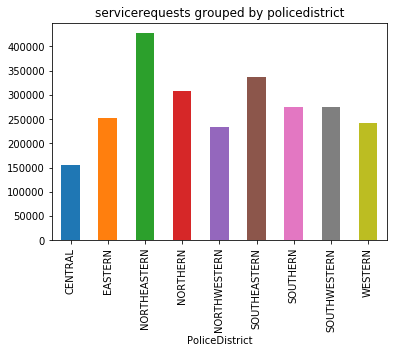

In [65]:
df_request.groupby(['PoliceDistrict']).count()['SRType'].plot(kind='bar', title = 'servicerequests grouped by policedistrict')

The service requests in each police district is counted and plot for police district vs its count is created.<br>
From the above plot we can see following insights.<br>
1. Central and Western districts havel least number of service requests.<br>
2. Northeastern has highest number of service requests.<br>

The previously seen crime incidents also follow the same pattern.

In [66]:
service_request_list = list(df_request.groupby(['PoliceDistrict']).count()['SRType'])
service_request_list_council = list(df_request.groupby(['CouncilDistrict']).count()['SRType'])

In [67]:
vacant_list = list(df_vacant.groupby(['PoliceDistrict']).count()['Lot'])
vacant_list_council = list(df_vacant.groupby(['CouncilDistrict']).count()['Lot'])

In [68]:
crime_list = list(df_crime[df_crime['District'] != 0].groupby(['District']).count()['Location'])
# crime_list_council = list(df_crime[df_crime['District'] != 0].groupby(['District']).count()['Location'])

In [70]:
relative_vacancy_list = list(relative_vacancy.values())
print(relative_vacancy_list)

[9.487581114343254, 18.72664926557142, 2.353866832770547, 6.828669404343593, 2.2361042095549086, 2.4150498840334276, 6.593798265415231, 8.803392204154672, 22.24112159167053]


ValueError: x and y must be the same size

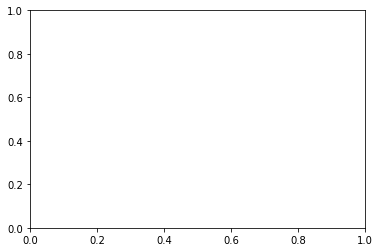

In [71]:
plt.scatter(service_request_list, vacant_list)

plt.title('Relationship between service request and vacant list')

plt.show()

After digging into this <b> error </b>, we found that one of the column had typo which resulted in duplicate column. Due to that vacant
buildings has one extra value. The following code will fix this problem.

In [72]:
print(len(service_request_list), len(vacant_list))

9 10


In [73]:
print(vacant_list)

[848, 3659, 9, 718, 1613, 945, 656, 1665, 2263, 4315]


In [74]:
vacant_list[2] = vacant_list[2] + vacant_list[5]

In [75]:
vacant_list.pop(5)

945

In [76]:
def sortMethod(l1, l2):
    return_list = []
    for i in range(len(l1)):
        return_list.append([l1[i], l2[i]])
    return_list = sorted(return_list)
    listy = [[], []]
    for i in range(len(return_list)):
        listy[0].append(return_list[i][0])
        listy[1].append(return_list[i][1])
    return listy

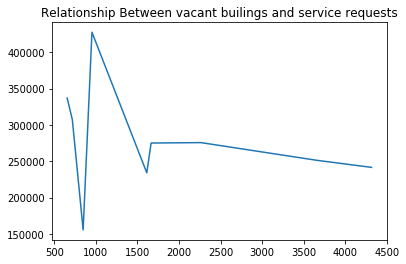

In [77]:
#Now plotting to see if there is any relationship between vacancy and service requests

plot_list = sortMethod(vacant_list, service_request_list)
plt.plot(plot_list[0], plot_list[1])
# plt.scatter(plot_list[0], plot_list[1])
plt.title('Relationship Between vacant builings and service requests')

plt.show()

Even though there are few outliers for lower values of vacant builings, the graph in overall is decreasing. This means that with increase in vacant buildings there are less service requests.

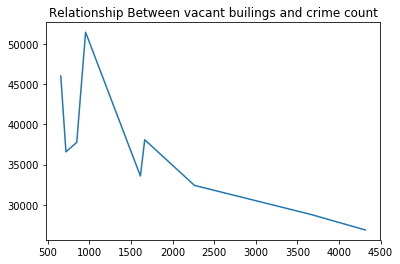

In [111]:
#Plot to see relation between vacancy and crime count
plot_list = sortMethod(vacant_list, crime_list)
plt.plot(plot_list[0], plot_list[1])
# plt.scatter(plot_list[0], plot_list[1])

plt.title('Relationship Between vacant builings and crime count')

plt.show()

From the above plot we can infer these things <br>
1) Increase in vacancy buildings cause less crime rate in that neighborhood

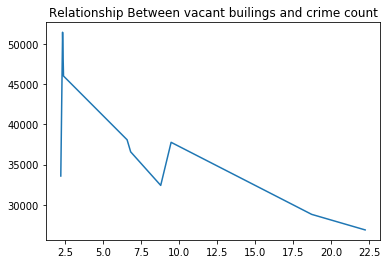

In [79]:
#Plot to check if relation holds for relative vacancy and crime count
plot_list = sortMethod(relative_vacancy_list, crime_list)
plt.plot(plot_list[0], plot_list[1])
# plt.scatter(plot_list[0], plot_list[1])

plt.title('Relationship Between relative vacant builings and crime count')
plt.show()

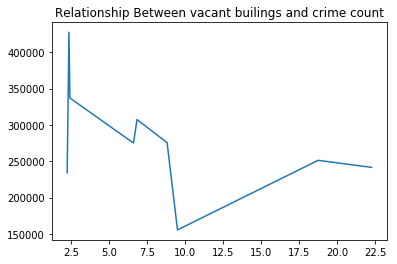

In [80]:
#Plot to check if relation holds for relative vacancy and service requests
plot_list = sortMethod(relative_vacancy_list, service_request_list)
plt.plot(plot_list[0], plot_list[1])
# plt.scatter(plot_list[0], plot_list[1])

plt.title('Relationship Between realative vacant builings and service requests')
plt.show()

The above plots will strengthen our assumptions because the relative buildings list also follows the same pattern as the vacant buildings list.

## Building Knn and RandomForestClassifier Models

In [81]:
df_vacant = df_vacant.drop(['Block','Lot','Neighborhood','PoliceDistrict','CouncilDistrict','Location'], axis=1)
df_vacant.isnull().sum(axis=0)
df_vacant['Status']=0

The vacant buildings are marked with a status of 0 and non vacant buildings are marked with a status of 1 which are used as labels for the model.

In [82]:
df_property = df_property.rename(columns = {"PropertyAddress": "BuildingAddress"}) 

In [83]:
df_res = pd.merge(df_vacant, df_property, on='BuildingAddress', how='outer')

Merging the vacant building and property taxes dataset by using Building address as the key for join operation.

In [84]:
df_res.isnull().sum(axis=0)

ReferenceID        222212
BuildingAddress         0
NoticeDate         222212
Status             222212
PropertyID            379
Block                 379
Lot                   379
Ward                  379
Sect                  379
LotSize               379
CityTax             19352
StateTax            19154
ResCode               379
AmountDue           99070
AsOfDate              379
Neighborhood        16500
PoliceDistrict        379
CouncilDistrict     16472
Location            16460
dtype: int64

In [85]:
df_res['Status']=df_res['Status'].fillna(1)

In [86]:
df_res.head()

,ReferenceID,BuildingAddress,NoticeDate,Status,PropertyID,Block,Lot,Ward,Sect,LotSize,CityTax,StateTax,ResCode,AmountDue,AsOfDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location
0,0002 019 031016,1909 W NORTH AVE,03/10/2016,0.0,0002019,0002,019,15.0,160.0,14X85,472.08,23.52,NOT A PRINCIPAL RESIDENCE,524.64,11/30/2018,Easterwood,Western,7.0,"(39.30952602, -76.64848892)"
1,0007 057 031116,1734 APPLETON ST,03/11/2016,0.0,0007057,0007,057,15.0,160.0,13-7X86,97.41,4.85,NOT A PRINCIPAL RESIDENCE,108.26,11/30/2018,Easterwood,Western,7.0,"(39.30856758, -76.64921158)"
2,0125 012 030816,522 N CAREY ST,03/08/2016,0.0,0125012,0125,012,19.0,10.0,17X104,67.44,3.36,NOT A PRINCIPAL RESIDENCE,74.94,11/30/2018,Harlem Park,Western,9.0,"(39.29482153, -76.63877572)"
3,0151 009 030716,317 N GILMOR ST,03/07/2016,0.0,0151009,0151,009,19.0,40.0,16X100,97.41,4.85,NOT A PRINCIPAL RESIDENCE,108.26,11/30/2018,Franklin Square,Western,9.0,"(39.29261889, -76.64231679)"
4,0151 009 100413,317 N GILMOR ST,10/04/2013,0.0,0151009,0151,009,19.0,40.0,16X100,97.41,4.85,NOT A PRINCIPAL RESIDENCE,108.26,11/30/2018,Franklin Square,Western,9.0,"(39.29261889, -76.64231679)"


In [87]:
df_res = df_res.drop(['ReferenceID','BuildingAddress','NoticeDate','LotSize','Location'], axis=1)
df_res = pd.concat([df_res,pd.get_dummies(df_res['ResCode'],prefix='ResCode')],axis=1)
df_res = df_res.drop(['AsOfDate','ResCode'], axis=1)
df_res = df_res.drop(['Neighborhood'], axis=1)
df_res = pd.concat([df_res,pd.get_dummies(df_res['PoliceDistrict'],prefix='PoliceDistrict')],axis=1)
df_res = df_res.drop(['PoliceDistrict'], axis=1)
df_res = df_res.drop(['PropertyID','Block','Lot'], axis=1)
df_res = df_res.dropna()

Dropping unnecessary attritbutes like PropertyId, Block, Lot etc from the datasets.

In [88]:
#Data Segregation into training and testing
from sklearn.model_selection import train_test_split
labels = df_res.pop('Status')

In [89]:
TrainData, TestData, TrainLabel, TestLabel = train_test_split(df_res, labels, test_size = 0.1, random_state = 10)

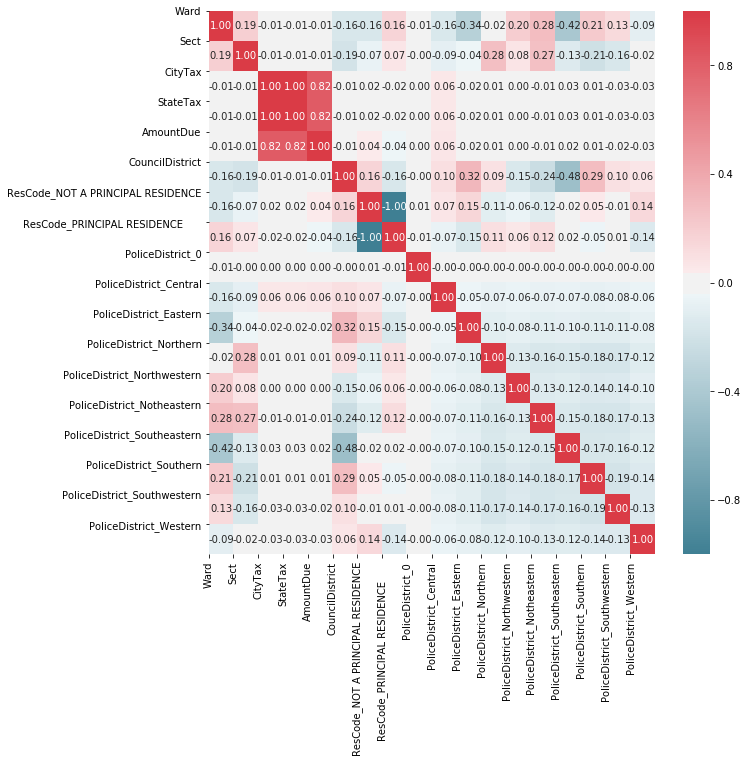

In [104]:
corr = df_res.corr()
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

The above heat map shows corelation between two columns. The only attributes with good corelation are <br>
 - City tax
 - State tax
 - Amount Due

In [94]:
from  sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFmodel = RFC.fit(TrainData,TrainLabel)
AccuracyTrain=RFmodel.score(TrainData,TrainLabel)
AccuracyTest=RFmodel.score(TestData,TestLabel)
print("Accuracy for Vacant train Data :",AccuracyTrain*100)
print("Accuracy for vacant test data :",AccuracyTest*100)
f = list(RFmodel.feature_importances_)

Accuracy for Vacant train Data : 97.72538351091967
Accuracy for vacant test data : 95.28487229862476


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KnnModel = KNeighborsClassifier()
KnnModel.fit(TrainData, TrainLabel)
KnnTrainAccuracy = KnnModel.score(TrainData, TrainLabel)
print("Accuracy of HR Training Data for KNN Algorithm is: ",KnnTrainAccuracy*100)
KnnTestAccuracy = KnnModel.score(TestData, TestLabel)
print("Accuracy of HR Testing Data for KNN Algorithm is: ",KnnTestAccuracy*100)

- The dataset when trained with Random forest classifer has a accuracy of 97% on the validation data and 95% on the test data
- When trained with Knn the acccuracies are about 95% for both the cases

In [95]:
importanceList = []
for key in f:
    importanceList.append(key*100)

In [96]:
df_res.columns

Index(['Ward', 'Sect', 'CityTax', 'StateTax', 'AmountDue', 'CouncilDistrict',
       'ResCode_NOT A PRINCIPAL RESIDENCE',
       'ResCode_PRINCIPAL RESIDENCE      ', 'PoliceDistrict_0',
       'PoliceDistrict_Central', 'PoliceDistrict_Eastern',
       'PoliceDistrict_Northern', 'PoliceDistrict_Northwestern',
       'PoliceDistrict_Notheastern', 'PoliceDistrict_Southeastern',
       'PoliceDistrict_Southern', 'PoliceDistrict_Southwestern',
       'PoliceDistrict_Western'],
      dtype='object')

In [97]:
columnsList = list(df_res.columns)

In [98]:
for i in range(len(columnsList)):
    print(columnsList[i] + " ---> " + str(importanceList[i]))

Ward ---> 4.322874588473496
Sect ---> 7.7262465263923525
CityTax ---> 24.33784019062489
StateTax ---> 30.611299282635635
AmountDue ---> 20.412379331688733
CouncilDistrict ---> 3.3071283552871025
ResCode_NOT A PRINCIPAL RESIDENCE ---> 2.830741742828997
ResCode_PRINCIPAL RESIDENCE       ---> 2.5885429379510567
PoliceDistrict_0 ---> 2.0928479339436864e-06
PoliceDistrict_Central ---> 0.21666048925451747
PoliceDistrict_Eastern ---> 0.19729841819597554
PoliceDistrict_Northern ---> 0.3682500025443614
PoliceDistrict_Northwestern ---> 0.23161108176382147
PoliceDistrict_Notheastern ---> 0.19345876641263712
PoliceDistrict_Southeastern ---> 0.22161454101800837
PoliceDistrict_Southern ---> 0.44611462284803327
PoliceDistrict_Southwestern ---> 0.3504654958147314
PoliceDistrict_Western ---> 1.6374715334177157


Here we have checked the feature importance for each column in the dataset and the inferred these <br>
1) City tax, state tax, amount due has a major impact in classifying the data <br>
2) Policedistrict columns is not so useful in classifying <br>
3) Principal residence did not have much impact on classifying the data <br>

In [100]:
df_vacant = pd.read_csv('Vacant_Buildings.csv') # Reading the data into the dataframe df
df_vacant = df_vacant[df_vacant['BuildingAddress'].notnull()]
df_vacant.isnull().sum(axis=0)
df_vacant['PoliceDistrict']=df_vacant['PoliceDistrict'].str.lower()
df_location = pd.DataFrame(columns=['ReferenceID','Latitude', 'Longitude'])


for i in range(0,len(df_vacant)):
    location = df_vacant.iloc[i]['Location'].split(',')
    Latitude = float(location[0][1:])
    Longitude = float(location[1][:-1])
    df_location.loc[i] = [df_vacant.iloc[i]['ReferenceID'],Latitude,Longitude]

In [101]:
result = pd.concat([df_vacant, df_location],axis=1, join_axes=[df_vacant.index])
result

,ReferenceID,Block,Lot,BuildingAddress,NoticeDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location,ReferenceID,Latitude,Longitude
0,0002 019 031016,0002,019,1909 W NORTH AVE,03/10/2016,EASTERWOOD,western,7,"(39.30952601, -76.64848892)",0002 019 031016,39.309526,-76.648489
1,0007 057 031116,0007,057,1734 APPLETON ST,03/11/2016,EASTERWOOD,western,7,"(39.30856758, -76.64921157)",0007 057 031116,39.308568,-76.649212
2,0125 012 030816,0125,012,522 N CAREY ST,03/08/2016,HARLEM PARK,western,9,"(39.29482152, -76.63877572)",0125 012 030816,39.294822,-76.638776
3,0151 009 030716,0151,009,317 N GILMOR ST,03/07/2016,FRANKLIN SQUARE,western,9,"(39.29261888, -76.64231678)",0151 009 030716,39.292619,-76.642317
4,0074 010 030918,0074,010,945 N MOUNT ST,03/09/2018,Sandtown-Winchester,western,9,"(39.29975212, -76.64415784)",0074 010 030918,39.299752,-76.644158
5,0275 060 030716,0275,060,319 S MONROE ST,03/07/2016,CARROLLTON RIDGE,southern,9,"(39.28383911, -76.64647246)",0275 060 030716,39.283839,-76.646472
6,0206 035 031418,0206,035,2023 W BALTIMORE ST,03/14/2018,Boyd-Booth,southwestern,9,"(39.28783131, -76.64939781)",0206 035 031418,39.287831,-76.649398
7,0599 008 031116,0599,008,235 PARK AVE,03/11/2016,DOWNTOWN,central,11,"(39.29280154, -76.6178644)",0599 008 031116,39.292802,-76.617864
8,0767 117 030816,0767,117,1329 SARGEANT ST,03/08/2016,WASHINGTON VILLAGE/PIGTOWN,southern,10,"(39.28035426, -76.63645611)",0767 117 030816,39.280354,-76.636456
9,0206 049 031418,0206,049,8 S PAYSON ST,03/14/2018,Boyd-Booth,southwestern,9,"(39.2875711, -76.64891445)",0206 049 031418,39.287571,-76.648914


In [113]:
from shapely.geometry import Point
result['Coordinates'] = list(zip(result.Longitude, result.Latitude))
result['Coordinates'] = result['Coordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(result, geometry='Coordinates')
gdf.plot(result['Coordinates'], color='red')
plt.show()

ModuleNotFoundError: No module named 'shapely'